In [51]:
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torch.distributions as t_dist

mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)
data_vec = mnist_trainset.data.view(60000, 28*28).float()

data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eigh(data_cov)

$W = U_M (L_M - \sigma^2 I)^{1/2}$  
U_M is DxM with columns being a subset of M eigenvectors of the covariance matrix.  
L_M is MxM diagonal with corresponding eigenvalues.  

In [52]:
D = data_eig.eigenvectors.shape[1]
z_dim = 10
sig_sq = 1/(D-z_dim)*torch.sum(data_eig.eigenvalues[:-z_dim])

U_M = data_eig.eigenvectors[:,-z_dim:]
L_M = torch.diag(data_eig.eigenvalues[-z_dim:])
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(z_dim))**0.5)

mu = torch.mean(data_vec, 0)

$p(z|x) = N(z | M^{-1}W^T(x-\mu), \sigma^{-2}M)$  
$M = W^T W + \sigma^2 I$

In [53]:
M = torch.matmul(W.T, W) + sig_sq * torch.eye(z_dim)

print(W.dtype)
temp = (data_vec - mu.unsqueeze(0)).T
z_values = torch.linalg.inv(M) @ W.T @ temp
print(z_values.size())


torch.float32
torch.Size([10, 60000])


In [54]:
if z_dim == 2:
    results_for_plot = z_values.numpy().T

    scatter_x = results_for_plot[:,0]
    scatter_y = results_for_plot[:,1]
    group = mnist_trainset.targets

    cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
            5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
    ax.legend(markerscale = 10)
    ax.set_xlabel('dimension 1')
    ax.set_ylabel('dimension 2')
    # ax.set_title(r"result of PPCA with $Z$ in two dimensions")
    plt.show()

### Calculate Likelihood of test data

In [55]:
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=None)
data_vec = mnist_testset.data.view(10000, 28*28).float()

# bishop book, page 572, formula (12.35, 12.36)
C = W @ W.T + sig_sq * torch.eye(mu.size(0))

x_distribution = t_dist.multivariate_normal.MultivariateNormal(mu, C)
log_p_x = x_distribution.log_prob(data_vec)
mean_log_p_x = log_p_x.mean()

print(mean_log_p_x)

tensor(-4158.3262)


In [56]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)
data_vec = mnist_trainset.data.view(60000, 28*28).float()

# bishop book, page 572, formula (12.35, 12.36)

x_distribution = t_dist.multivariate_normal.MultivariateNormal(mu, C)
log_p_x = x_distribution.log_prob(data_vec)
mean_log_p_x = log_p_x.mean()
# ll = -60000/2*(784*torch.log(torch.tensor([torch.pi]))+torch.log(torch.det(C))+torch.sum(torch.trace(torch.cholesky_inverse(C)*data_cov)))
print(mean_log_p_x)
# print(ll)

tensor(-4162.1958)


/var/folders/8m/mzjjkq5n6cxfldg8wbgv1sh40000gn/T/ipykernel_44538/934788069.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


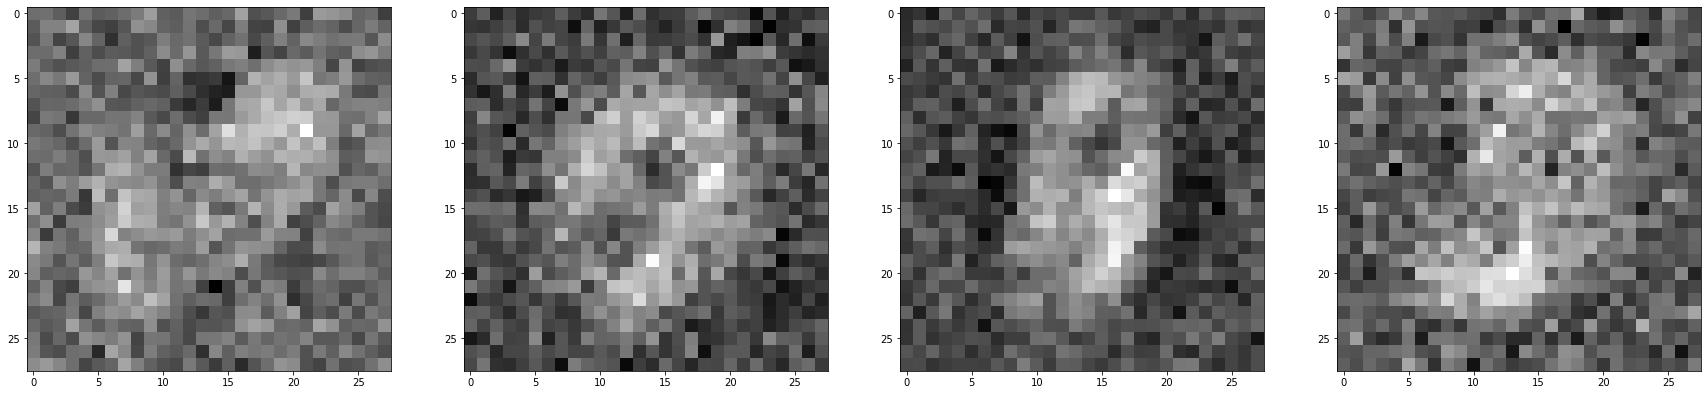

In [61]:
num = 4
samples = x_distribution.sample(torch.Size([num]))
fig, ax = plt.subplots(ncols=num)
for i in range(num):
    ax[i].imshow(samples[i].cpu().view(28,28), cmap='gray')

fig.set_size_inches(30,30)
fig.show()

/var/folders/8m/mzjjkq5n6cxfldg8wbgv1sh40000gn/T/ipykernel_44538/2139910719.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


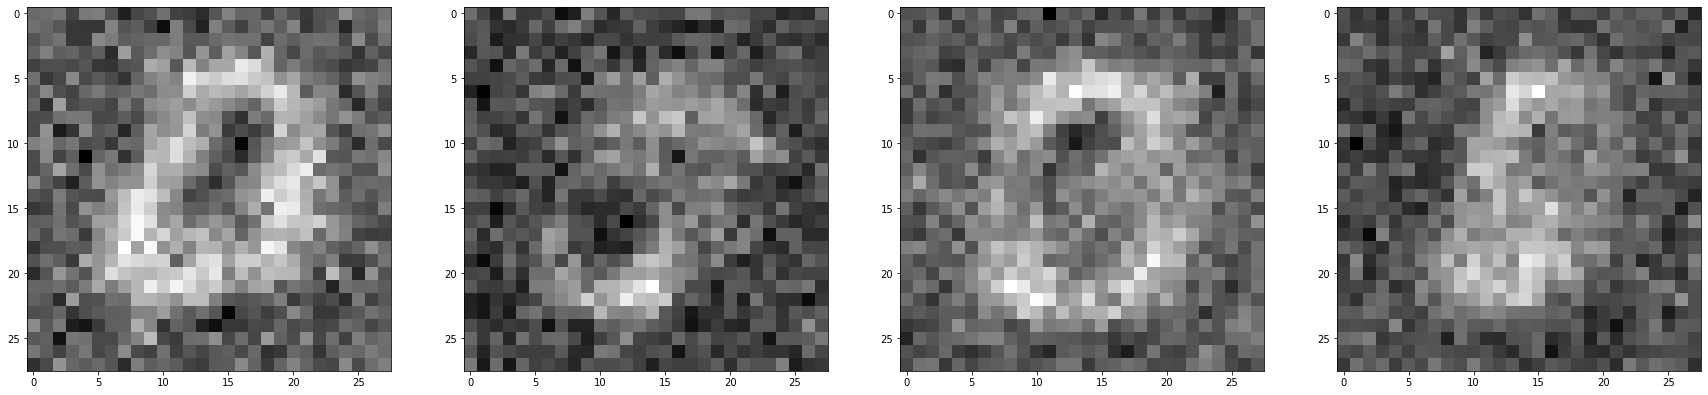

In [63]:
num = 4
samples = []
for i in range(num):
    z_dis = t_dist.MultivariateNormal(torch.zeros(z_dim), torch.eye(z_dim))
    z = z_dis.sample()
    # print((W@z+mu).shape)
    x_dis = t_dist.MultivariateNormal((W@z+mu).to(torch.float32),(sig_sq*np.eye(28*28)).to(torch.float32))
    samples.append(x_dis.sample())
# samples = x_distribution.sample(torch.Size([num]))
fig, ax = plt.subplots(ncols=num)
for i in range(num):
    ax[i].imshow(samples[i].cpu().view(28,28), cmap='gray')

fig.set_size_inches(30,30)
fig.show()